# DFA example on MNIST
Notebook version of https://github.com/lightonai/dfa-scales-to-modern-deep-learning/blob/master/TinyDFA/mnist_example.py

Shun Li, 04/12/24

## Initialize and load dataset

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import torchvision.datasets as datasets

from tinydfa import DFA, DFALayer, FeedbackPointsHandling

from EPLHb import EPLHb, gd, adam

import numpy as np
from scipy import stats
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
# Downloading MNIST data

mnist_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.MNIST(root = './data', train = True,
                        transform = mnist_transform, download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = mnist_transform)

# Loading the data
batch_size = 100 # the size of input data took for one iteration

train_loader = torch.utils.data.DataLoader(dataset = train_data,batch_size = batch_size,shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,batch_size = batch_size,shuffle = False)

## DFA methods

In [3]:
# Fully connected neural network
class MNISTFullyConnected(nn.Module):
    def __init__(self, hidden_size, training_method='DFA'):
        super(MNISTFullyConnected, self).__init__()
        self.fc1 = nn.Linear(784, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)

        self.training_method = training_method
        if self.training_method in ['DFA', 'SHALLOW']:
            self.dfa1, self.dfa2 = DFALayer(), DFALayer()
            self.dfa = DFA([self.dfa1, self.dfa2], feedback_points_handling=FeedbackPointsHandling.LAST,
                           no_training=(self.training_method == 'SHALLOW'))

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        if self.training_method in ['DFA', 'SHALLOW']:
            x = self.dfa1(torch.relu(self.fc1(x)))
            x = self.dfa2(torch.relu(self.fc2(x)))
            x = self.dfa(self.fc3(x))
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        return x

In [4]:
def train(train_loader, model, optimizer, device, epoch):
    model.train()
    for b, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        print(f"Training loss at batch {b}: {loss.item():.4f}", end='\r')

    return loss.detach().numpy().item()


def test(test_loader, model, device, epoch):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for b, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset) * 100
    print(f"Epoch {epoch}: test loss {test_loss:.4f}, accuracy {accuracy:.2f}.")
    return accuracy

In [5]:
EP_size = 784 # img_size = (28,28) ---> 28*28=784 in total
LHb_size = 500 # number of nodes at hidden layer
DAN_size = 10 # number of output classes discrete range [0,9]
num_epochs = 1 # number of times which the entire dataset is passed throughout the model
lr = 1e-3 # size of step
momentum = 0.9 # a parameter used to help the model to converge faster

prob_EP_to_LHb = 1
prob_LHb_to_LHb = 1
prob_LHb_to_DAN = 1

# DFA specific params
training_method = 'DFA' # can be 'BP', 'DFA', 'SHALLOW'

## Train models

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

model = MNISTFullyConnected(LHb_size, training_method=training_method).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

loss_history, accuracy_history = [], []

for epoch in range(1, num_epochs + 1):
    cur_loss = train(train_loader, model, optimizer, device, epoch)
    cur_accuracy = test(test_loader, model, device, epoch)

    loss_history.append(cur_loss)
    accuracy_history.append(cur_accuracy)

torch.Size([100, 500])
torch.Size([100, 500])
DFABackend backward
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 0: 2.3117
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 1: 2.2992
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 2: 2.3021
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 3: 2.3109
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 4: 2.3067
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 5: 2.3086
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 6: 2.2939
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 7: 2.3167
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 8: 2.2940
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 9: 2.2888
Random projection size:  torch.Size([100, 500])
DFABackend backwardtch 10: 2.2973
Random projection size:  torch.Size([100, 

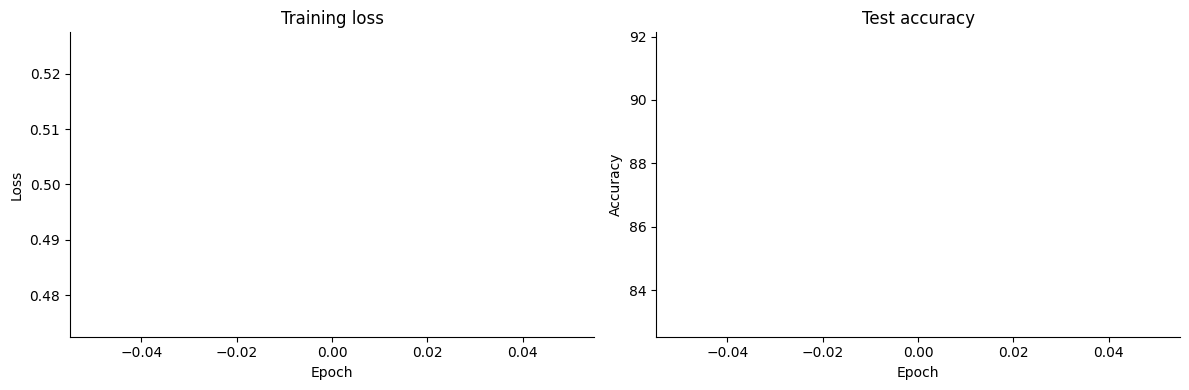

In [7]:
# Plot loss and accuracy history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_history)
plt.title('Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()